In [1]:
import torch
# from torch.utils.data import DataLoader, Dataset
# from skmultilearn.model_selection import iterative_train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
from skmultilearn.model_selection import iterative_train_test_split

In [ ]:
# class ProtDataset(Dataset):
#     def __init__(self, x, y):
#         super(ProtDataset, self).__init__()
#         assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
#         self.x = x
#         self.y = y

#     def __len__(self):
#         return self.y.shape[0]

#     def __getitem__(self, index):
#         return self.x[index], self.y[index]

In [2]:
with open('d:\\year 4\\semester 1\\BT\\BT 4033\\prediction\\labels\\bp_terms_class_order.pkl', 'rb') as f:
    go_terms_order = pickle.load(f)

In [3]:
with open('d:\\year 4\\semester 1\\BT\\BT 4033\\prediction\\datasets\\bp_dataset.pkl', 'rb') as f:
    prior_dataset = pickle.load(f)

In [4]:
inputs = np.array([vect['vect'] for vect in prior_dataset.values()])
outputs = np.array([vect['enc_label'] for vect in prior_dataset.values()])

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42, stratify=outputs, shuffle=True)
X_train, y_train, X_test, y_test = iterative_train_test_split(inputs, outputs,test_size=0.20)

In [7]:
X_train.shape

(13823, 225)

In [9]:
y_train.shape

(13823, 296)

In [8]:
train_class_counts = np.sum(y_train == 1, axis=0)
  # Sum along rows for each class
classes = torch.arange(len(train_class_counts))  # Class indices

In [11]:
print(train_class_counts)

[ 364   72  198  330  180 1198  123   54   62   72 1180  436   80  360
  304  198  103  359   96   48  956   48  225  108   48  125  205   60
   65  460 1228  932  305  198  198   72   62   72   62   56   80  128
   48  128   71   65  328  520  366 1524  118  868  264  320  624  198
  210  928  324  231  276   94  285  214  972  105   88  112  245  250
  811  646   72 1664   41   46   48  208   48   44  240  140   68   48
 1584  640   52  138  110   71  508  639  296  646  152  536  463   84
   91 1608   48  161 1310  199  216   44  282  392 1133  134  416  104
  198   40   88  204   65   96  420  272   94   72   48   48   62   90
   71  395  350  268   68   40  245  198  216  321  661  848  136   92
  204  132  225   76  118  305   70   89  282  336   62  268  274  120
   80   40   98   48  184   80  184   65   65  625  352  264   44   68
   80  272   44   72  281  125  112   67  444  132  378  278  264   56
  332   40  184  288   80   96   44  286   71 2606  318  184   40  376
  288 

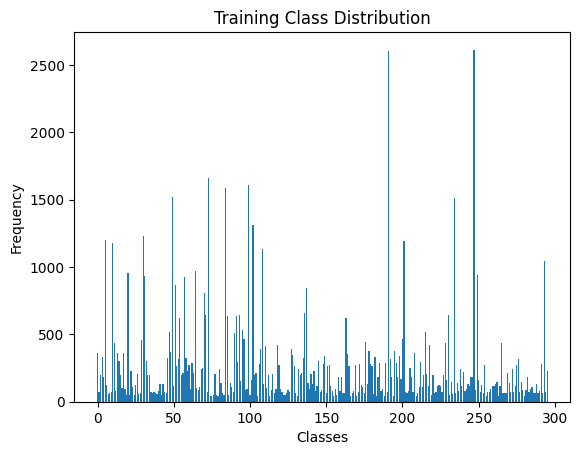

In [12]:
plt.bar(classes, train_class_counts)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Training Class Distribution')
plt.show()

In [9]:
class_weights = y_train.shape[0]/(train_class_counts)    # from deep fri 

In [10]:
weight_tensor = torch.tensor(class_weights)

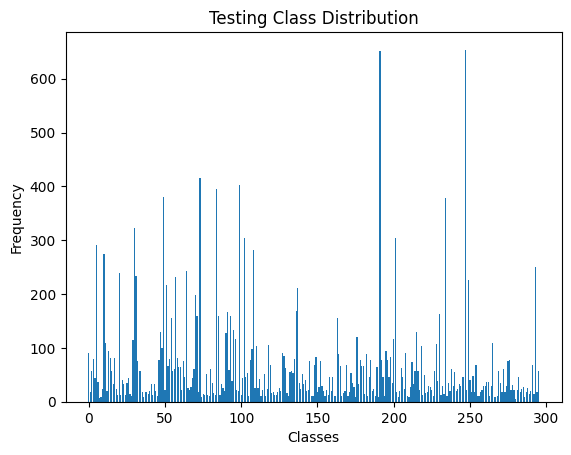

In [15]:
test_class_counts = np.sum(y_test == 1, axis=0)
plt.bar(classes, test_class_counts)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Testing Class Distribution')
plt.show()

In [11]:
# Define the model
class BP_PredictorModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(BP_PredictorModel, self).__init__()
        self.input_layer = nn.Linear(input_size, input_size)
        self.middle_layer = nn.Linear(input_size, input_size)
        self.output_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.input_layer(x).relu()
        x = self.middle_layer(x).relu()
        
        x = self.output_layer(x)
        return x

In [13]:
model = BP_PredictorModel(225, 296)

In [14]:
# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight= weight_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
import matplotlib.pyplot as plt

# Lists to store accuracy values for plotting
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

In [ ]:
def calculate_accuracy(predictions, labels, threshold=0.5):
    """
    Calculate multi-label accuracy.
    - predictions: Model outputs (probabilities after sigmoid).
    - labels: Ground truth labels.
    - threshold: Threshold to convert probabilities to binary labels (default 0.5).
    """
    # # Apply threshold to convert probabilities to binary predictions
    # predicted_labels = (predictions > threshold).float()
   
    # Iterate over each class (column)
    num_classes = labels.shape[1]
    TP, FP, TN, FN = 0, 0, 0, 0

    for class_idx in range(num_classes):
        y_true = labels[:, class_idx]
        y_pred = predictions[:, class_idx]
        
        # Calculate TP, TN, FP, FN
        tp = np.sum((y_true == 1) & (y_pred == 1), axis=0)
        tn = np.sum((y_true == 0) & (y_pred == 0), axis=0)
        fp = np.sum((y_true == 0) & (y_pred == 1), axis=0)
        fn = np.sum((y_true == 1) & (y_pred == 0), axis=0)
        
        TP += tp
        FP += fp
        TN += tn
        FN += fn
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return accuracy

In [17]:
def train_model(model, inputs, labels, criterion, optimizer):
    model.train()  # Set model to training mode

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute loss
    loss = criterion(outputs, labels)
    train_losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    probabilities = outputs.sigmoid()  # Convert logits to probabilities
    accuracy = calculate_accuracy(probabilities, labels)
    train_accuracies.append(accuracy)
    # Return the loss
    return loss.item(), accuracy 


# Testing function without batching
def test_model(model, inputs, labels, criterion):
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for testing
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

    # Apply sigmoid to outputs for multi-label probabilities
    probabilities = outputs.sigmoid()
    accuracy = calculate_accuracy(probabilities, labels)
    test_accuracies.append(accuracy)

    # Return the loss and predictions
    return loss.item(), accuracy

In [19]:
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
minmax_scaled_train_data = torch.from_numpy(minmax_scaler.fit_transform(X_train)).float()

In [20]:
minmax_scaled_test_data = torch.from_numpy(minmax_scaler.transform(X_test)).float()

In [21]:
train_label = torch.from_numpy(y_train).float()
                               
test_label = torch.from_numpy(y_test).float()

In [ ]:
# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    # Train
    train_loss, train_accuracy = train_model(model, minmax_scaled_train_data, train_label, criterion, optimizer)

    # Test (optional: use a separate test dataset)
    test_loss, test_accuracy = test_model(model, minmax_scaled_test_data, test_label, criterion)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [23]:
torch.save(model.state_dict(), 'bp_predictor_final.pt')

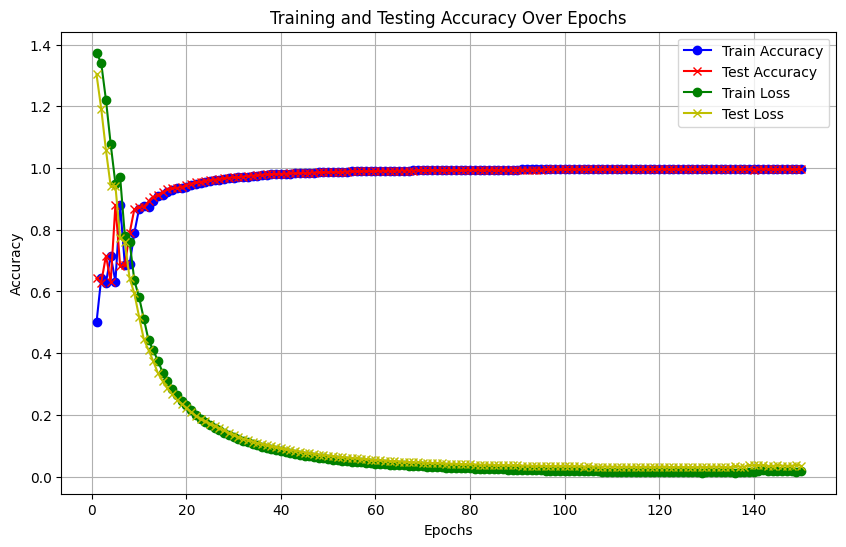

In [24]:
# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='b', linestyle='-', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='r', linestyle='-', marker='x')

plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='g', linestyle='-', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='y', linestyle='-', marker='x')

plt.title('Training and Testing Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
true_labels = y_test.astype(int)

model.eval()
with torch.no_grad():
    # Forward pass to get model predictions
    outputs = model(minmax_scaled_test_data).sigmoid().numpy()
predicted_labels = (outputs > 0.5).astype(int)

c:\Users\sachintha\anaconda3\envs\ppi_dl\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


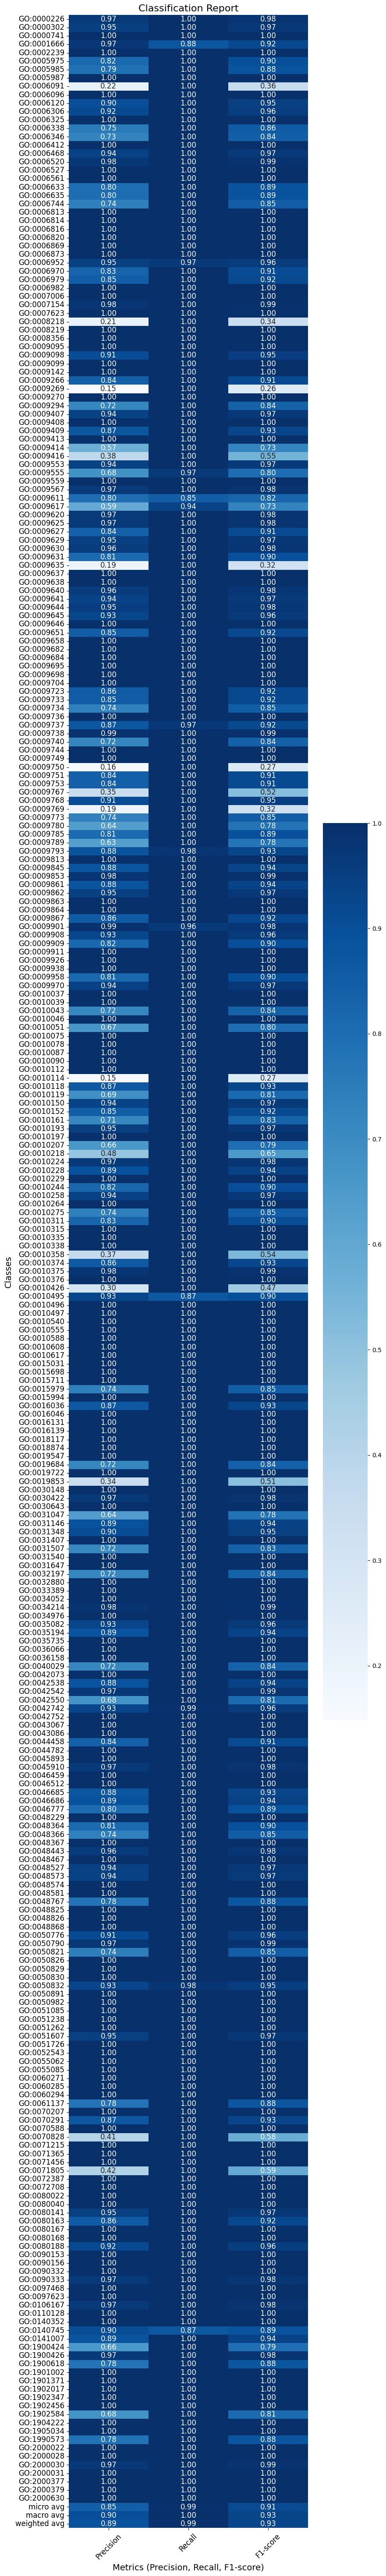

In [26]:
from sklearn.metrics import classification_report
cr = classification_report(true_labels, predicted_labels, output_dict= True, target_names= go_terms_order)
report_df = pd.DataFrame(cr).transpose()
# Plot the classification report as a heatmap
plt.figure(figsize=(10, 60))  # Increased figure size for better spacing
sns.heatmap(report_df.iloc[:-1, :-1].astype(float), annot=True, cmap="Blues", fmt='.2f', cbar=True, 
            annot_kws={"size": 12})  # Increase the size of the annotation text

# Customize the plot for better visibility
plt.title("Classification Report", fontsize=16)
plt.ylabel("Classes", fontsize=14)
plt.xlabel("Metrics (Precision, Recall, F1-score)", fontsize=14)
plt.xticks(np.arange(3) + 0.5, ['Precision', 'Recall', 'F1-score'], rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)  # Increase font size for y-axis labels

# Adjust layout to avoid overlapping
plt.tight_layout(pad=5)  # Increase padding between plot elements

# Show the plot
plt.show()

Overall ROC AUC: 1.00


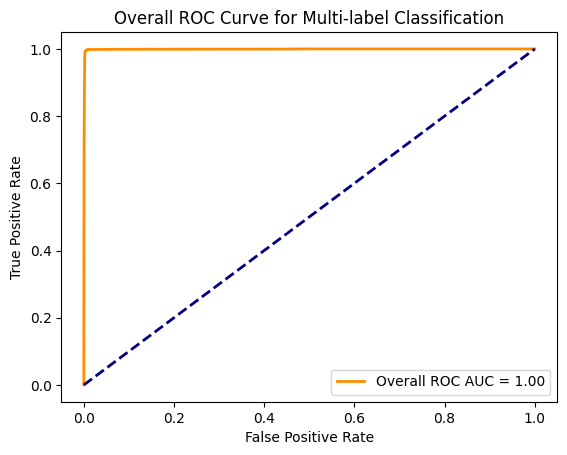

In [27]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
# To calculate the overall ROC curve across all labels
# Flatten the labels and predictions for combined ROC
y_true_flat = true_labels.ravel()
y_pred_flat = outputs.ravel()

fpr_all, tpr_all, _ = roc_curve(y_true_flat, y_pred_flat)
roc_auc_all = auc(fpr_all, tpr_all)

print(f"Overall ROC AUC: {roc_auc_all:.2f}")

# Plot combined ROC
plt.figure()
plt.plot(fpr_all, tpr_all, color='darkorange', lw=2, label=f'Overall ROC AUC = {roc_auc_all:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve for Multi-label Classification')
plt.legend(loc="lower right")
plt.show()

Overall PR AUC: 0.95


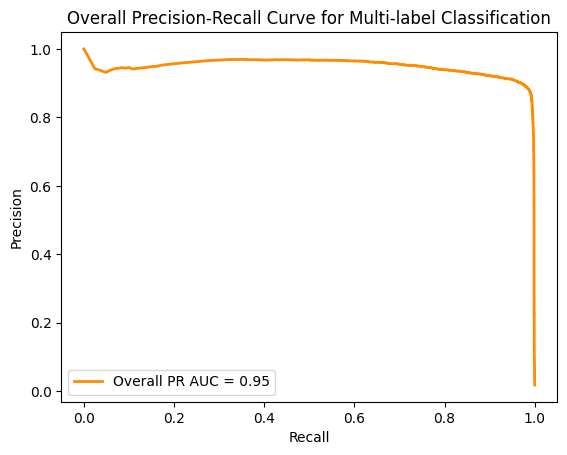

In [28]:
precision_all, recall_all, _ = precision_recall_curve(y_true_flat, y_pred_flat)
pr_auc_all = auc(recall_all, precision_all)

print(f"Overall PR AUC: {pr_auc_all:.2f}")

# Plot combined PR curve
plt.figure()
plt.plot(recall_all, precision_all, color='darkorange', lw=2, label=f'Overall PR AUC = {pr_auc_all:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Overall Precision-Recall Curve for Multi-label Classification')
plt.legend(loc="lower left")
plt.show()

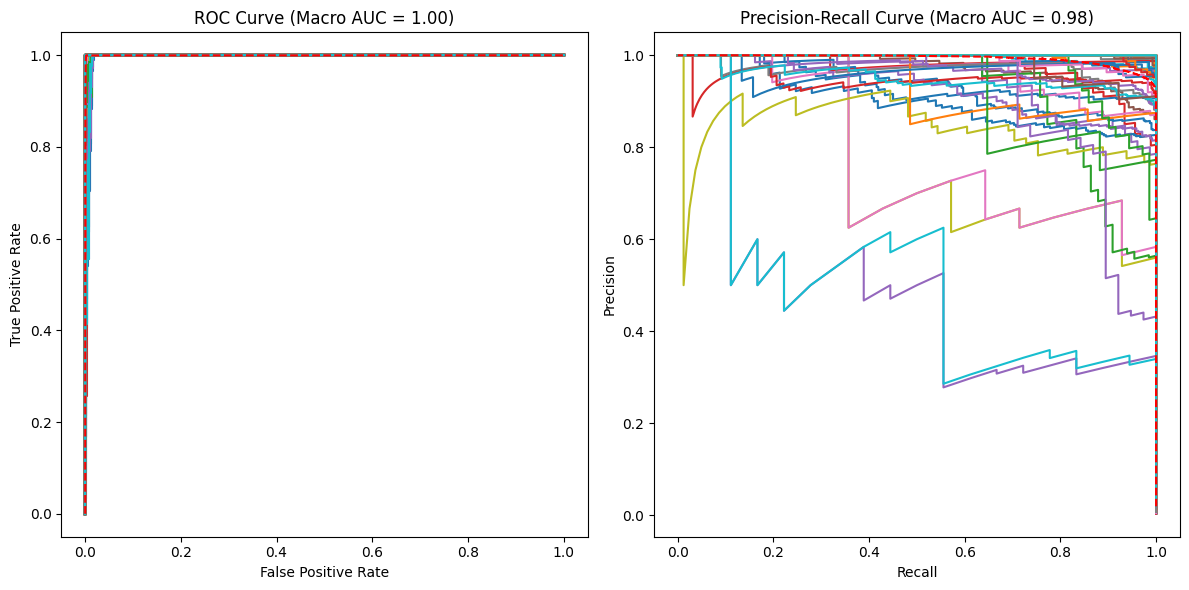

<Figure size 800x600 with 0 Axes>

In [51]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
# Calculate AUROC and AUPR for each label
roc_auc_values = []
pr_auc_values = []
fprs, tprs, precisions, recalls = [], [], [], []

for i in range(120):
    fpr, tpr, _ = roc_curve(true_labels[:, i], outputs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)
    fprs.append(fpr)
    tprs.append(tpr)

    precision, recall, _ = precision_recall_curve(true_labels[:, i], outputs[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)
    precisions.append(precision)
    recalls.append(recall)

# Macro AUROC and AUPR
macro_roc_auc = np.mean(roc_auc_values)
macro_pr_auc = np.mean(pr_auc_values)

# Micro AUROC and AUPR
fpr_micro, tpr_micro, _ = roc_curve(true_labels.ravel(), outputs.ravel())
micro_roc_auc = auc(fpr_micro, tpr_micro)

precision_micro, recall_micro, _ = precision_recall_curve(true_labels.ravel(), outputs.ravel())
micro_pr_auc = auc(recall_micro, precision_micro)

# Plot AUROC and AUPR Violin Plots
# auc_df = pd.DataFrame({
#     'Metric': ['ROC AUC'] * len(roc_auc_values) + ['PR AUC'] * len(pr_auc_values),
#     'Value': roc_auc_values + pr_auc_values
# })

# plt.figure(figsize=(12, 6))
# sns.violinplot(x='Metric', y='Value', data=auc_df)
# plt.title('Distribution of AUROC and AUPR')
# # plt.savefig('auroc_aupr_violin_plot.png')
# plt.show()

# Plot ROC and PR Curves
plt.figure(figsize=(12, 6))

# Plot ROC Curves
plt.subplot(1, 2, 1)
for i in range(120):
    plt.plot(fprs[i], tprs[i], label=f'Label {i} (AUC = {roc_auc_values[i]:.2f})')
plt.plot(fpr_micro, tpr_micro, label=f'Micro Average (AUC = {micro_roc_auc:.2f})', linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Macro AUC = {macro_roc_auc:.2f})')
# plt.legend(loc='best')

# Plot PR Curves
plt.subplot(1, 2, 2)
for i in range(120):
    plt.plot(recalls[i], precisions[i], label=f'Label {i} (AUC = {pr_auc_values[i]:.2f})')
plt.plot(recall_micro, precision_micro, label=f'Micro Average (AUC = {micro_pr_auc:.2f})', linestyle='--', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Macro AUC = {macro_pr_auc:.2f})')
# plt.legend(loc='best')

plt.tight_layout()
# plt.savefig('roc_pr_curves.png')
plt.show()

# Compute Confusion Matrix: Calculate TP, FP, TN, FN for each label and sum them
TP, FP, TN, FN = 0, 0, 0, 0
for i in range(120):
    predicted = (true_labels[:, i] >= 0.5).astype(int)
    actual = true_labels[:, i]
    
    tp = np.sum((predicted == 1) & (actual == 1), axis=0)
    fp = np.sum((predicted == 1) & (actual == 0), axis=0)
    tn = np.sum((predicted == 0) & (actual == 0), axis=0)
    fn = np.sum((predicted == 0) & (actual == 1), axis=0)

    TP += tp
    FP += fp
    TN += tn
    FN += fn

# Final aggregated confusion matrix
conf_matrix = np.array([[TP, FP], [FN, TN]])

# Plot aggregated confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Positive', 'Negative'])
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
# plt.savefig('confusion_matrix.png')
plt.show()

In [52]:
# Number of classes (columns)
num_classes = true_labels.shape[1]

# Initialize a dictionary to store the metrics for each class
metrics_per_class = {}

In [53]:
# Iterate over each class (column)
for class_idx in range(num_classes):
    y_true = true_labels[:, class_idx]
    y_pred = predicted_labels[:, class_idx]
    
    # Calculate TP, TN, FP, FN
    tp = np.sum((y_true == 1) & (y_pred == 1), axis=0)
    tn = np.sum((y_true == 0) & (y_pred == 0), axis=0)
    fp = np.sum((y_true == 0) & (y_pred == 1), axis=0)
    fn = np.sum((y_true == 1) & (y_pred == 0), axis=0)
    
    # Store the results in the dictionary
    metrics_per_class[f'Class {class_idx}'] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    }

In [54]:
metrics_df = pd.DataFrame(metrics_per_class).T
metrics_df.head()

TP    TN  FP  FN
Class 0  91  3377   0   0
Class 1  18  3449   1   0
Class 2  51  3417   0   0
Class 3  82  3385   1   0
Class 4  45  3423   0   0

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [56]:
# Function to plot confusion matrices for each class
def plot_confusion_matrices(metrics_df, per_row=4):
    num_classes = len(metrics_df)
    rows = (num_classes + per_row - 1) // per_row  # Calculate required rows
    
    fig, axes = plt.subplots(rows, per_row, figsize=(5 * per_row, 5 * rows))
    axes = axes.flatten()  # Flatten axes for easy iteration
    
    for idx, (class_name, metrics) in enumerate(metrics_df.iterrows()):
        # Extract confusion matrix values
        tp, fn, fp, tn = metrics['TP'], metrics['FN'], metrics['FP'], metrics['TN']
        confusion_matrix = np.array([[tp, fn], [fp, tn]])  # Arrange elements accordingly
        
        # Plot using sklearn
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Positive', 'Negative'])
        disp.plot(cmap=plt.cm.Blues, ax=axes[idx])
        axes[idx].set_title(f"Confusion Matrix for {class_name}")
    
    # Hide any unused subplots
    for idx in range(len(metrics_df), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

In [57]:
plot_confusion_matrices(metrics_df, per_row=4)

In [ ]:

for train_index, test_index in msss.split(inputs, outputs):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = inputs[train_index], inputs[test_index]
   y_train, y_test = outputs[train_index], outputs[test_index]

   train_class_counts = np.sum(y_train == 1, axis=0)
  # Sum along rows for each class
   classes = torch.arange(len(train_class_counts))  # Class indices
   class_weights = y_train.shape[0]/(train_class_counts)    # from deep fri 
   weight_tensor = torch.tensor(class_weights)
   
   model = BP_PredictorModel(225, 296)

   # Criterion and Optimizer
   criterion = nn.BCEWithLogitsLoss(pos_weight= weight_tensor)
   optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
   
   # Lists to store accuracy values for plotting
   train_accuracies = []
   test_accuracies = []
   train_losses = []
   test_losses = []

   train_label = torch.from_numpy(y_train).float()                            
   test_label = torch.from_numpy(y_test).float()

   # Training loop
   num_epochs = 100
   for epoch in range(num_epochs):
      # Train
      train_loss, train_accuracy = train_model(model, torch.from_numpy(X_train).float(), train_label, criterion, optimizer)
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Test (optional: use a separate test dataset)
      test_loss, test_accuracy = test_model(model, torch.from_numpy(X_test).float(), test_label, criterion)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)
      # print(f"Epoch {epoch + 1}/{num_epochs}, "
      #       f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
      #       f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
   

   true_labels = y_test.astype(int)

   model.eval()
   with torch.no_grad():
      # Forward pass to get model predictions
      outputs = model(torch.from_numpy(X_test).float()).sigmoid().numpy()
   predicted_labels = (outputs > 0.5).astype(int)
   
   y_true_flat = true_labels.ravel()
   y_pred_flat = outputs.ravel()

   fpr_all, tpr_all, _ = roc_curve(y_true_flat, y_pred_flat)
   roc_auc_all = auc(fpr_all, tpr_all)
   precision_all, recall_all, _ = precision_recall_curve(y_true_flat, y_pred_flat)
   pr_auc_all = auc(recall_all, precision_all)

   fig, axes = plt.subplots(2, 2, figsize=(12, 5))  # 1 row, 2 columns

   axes[0][0].plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='b', linestyle='-', marker='o')
   axes[0][0].plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='r', linestyle='-', marker='x')
   axes[0][0].set_title('Accuracy')
   axes[0][0].set_xlabel('Epoch')
   axes[0][0].set_ylabel('Accuracy')
   axes[0][0].legend()

   axes[0][1].plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='g', linestyle='-', marker='o')
   axes[0][1].plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='r', linestyle='-', marker='x')
   axes[0][1].set_title('Loss')
   axes[0][1].set_xlabel('Epoch')
   axes[0][1].set_ylabel('Loss')
   axes[0][1].legend()  

   axes[1][0].plot(fpr_all, tpr_all, color='darkorange', lw=2, label=f'Overall ROC AUC = {roc_auc_all:.2f}')
   axes[1][0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   axes[1][0].set_title('Overall ROC Curve for Multi-label Classification')
   axes[1][0].set_xlabel('False Positive Rate')
   axes[1][0].set_ylabel('True Positive Rate')
   axes[1][0].legend(loc="lower right")  

   axes[1][1].plot(recall_all, precision_all, color='darkorange', lw=2, label=f'Overall PR AUC = {pr_auc_all:.2f}')
   # axes[1][1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   axes[1][1].set_title('Overall Precision-Recall Curve for Multi-label Classification')
   axes[1][1].set_xlabel('Recall')
   axes[1][1].set_ylabel('Precision')
   axes[1][1].legend(loc="lower left")  
   
   plt.tight_layout()
   plt.show()

In [ ]:
# input_train_splits, input_test_splits, label_train_splits, label_test_splits = [], [], [], []

for fold, (train_index, test_index) in enumerate(kfold.split(outputs)):
# for train_index, test_index in mlskf.split(inputs, outputs):  # print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = inputs[train_index], inputs[test_index]
   y_train, y_test = outputs[train_index], outputs[test_index]

   train_class_counts = np.sum(y_train == 1, axis=0)
  # Sum along rows for each class
   classes = torch.arange(len(train_class_counts))  # Class indices
   class_weights = y_train.shape[0]/(train_class_counts)    # from deep fri 
   weight_tensor = torch.tensor(class_weights)
   
   model = BP_PredictorModel(225, 296)

   # Criterion and Optimizer
   criterion = nn.BCEWithLogitsLoss(pos_weight= weight_tensor)
   optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
   
   # Lists to store accuracy values for plotting
   train_accuracies = []
   test_accuracies = []
   train_losses = []
   test_losses = []

   train_label = torch.from_numpy(y_train).float()                            
   test_label = torch.from_numpy(y_test).float()

   # Training loop
   num_epochs = 5
   for epoch in range(num_epochs):
      # Train
      train_loss, train_accuracy = train_model(model, torch.from_numpy(X_train).float(), train_label, criterion, optimizer)
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Test (optional: use a separate test dataset)
      test_loss, test_accuracy = test_model(model, torch.from_numpy(X_test).float(), test_label, criterion)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)

      print(f"Epoch {epoch + 1}/{num_epochs}, "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
   
      # Plotting the accuracies
   fig, axes = plt.subplots(2, 2, figsize=(30, 20))  # 1 row, 2 columns
   axes[0][0].plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='b', linestyle='-', marker='o')
   axes[0][0].plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='r', linestyle='-', marker='x')
   axes[0][0].set_title('Training and Testing Accuracy')
   axes[0][0].set_xlabel('Epoch')
   axes[0][0].set_ylabel('Accuarcy')
   axes[0][0].legend()

   axes[0][1].plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='g', linestyle='-', marker='o')
   axes[0][1].plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='y', linestyle='-', marker='x')
   axes[0][1].set_title('Training and Testing Loss')
   axes[0][1].set_xlabel('Epoch')
   axes[0][1].set_ylabel('Loss')
   axes[0][1].legend()


   true_labels = y_test.astype(int)

   model.eval()
   with torch.no_grad():
      # Forward pass to get model predictions
      outputs = model(torch.from_numpy(X_test).float()).sigmoid().numpy()
   predicted_labels = (outputs > 0.5).astype(int)

   y_true_flat = true_labels.ravel()
   y_pred_flat = outputs.ravel()

   fpr_all, tpr_all, _ = roc_curve(y_true_flat, y_pred_flat)
   roc_auc_all = auc(fpr_all, tpr_all)
   axes[1][0].plot(fpr_all, tpr_all, color='darkorange', lw=2, label=f'Overall ROC AUC = {roc_auc_all:.2f}')
   axes[1][0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   axes[1][0].set_title('Overall ROC Curve for Multi-label Classification')
   axes[1][0].set_xlabel('False Positive Rate')
   axes[1][0].set_ylabel('True Positive Rate')
   axes[1][0].legend(loc="lower right")

   precision_all, recall_all, _ = precision_recall_curve(y_true_flat, y_pred_flat)
   pr_auc_all = auc(recall_all, precision_all)

   axes[1][1].plot(recall_all, precision_all, color='darkorange', lw=2, label=f'Overall PR AUC = {pr_auc_all:.2f}')
   axes[1][1].set_title('Overall Precision-Recall Curve for Multi-label Classification')
   axes[1][1].set_xlabel('Recall')
   axes[1][1].set_ylabel('Precision')
   axes[1][1].legend(loc="lower left")

   plt.tight_layout()
   plt.show()